# $\Delta$ARG LEU$^{++}$ Monoculture Model

Authors: Daniel Strohmeier, Stephan Noack (2022) 

### Assumptions


* Continuity
* Population average considered
* Ideally mixed reactor
* No oxygen or secondary substrate limitations (except auxotrophic amino acids)
* Uptake rates obey a Monod-type kinetic
* Secretion rates are lumped rates over the amino acid synthesis reactions and the transport to the bulk phase
* The substrate specific biomass yield $Y_{SX}^{dA}$ is the same as of the lysine-producer strain *C. glutamicum ATCC 17965 - Kjeldesen 2008*
* Constant and known specific volume of bacteria
* No maintenance metabolism considered


### Used Packages

* pyFOOMB - *Hemmerich 2021*
* Numpy
* Pandas
* joblib
* os

### Import of Required Libraries

In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import TimeSeries
from pyfoomb import Helpers
from pyfoomb import Measurement
from pyfoomb import ObservationFunction
from pyfoomb import ParameterMapper
import joblib
import os.path

import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
numpy.random.seed(123)

Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


# 1. Bioprocess Model

## Kinetics

### Monod Kinetic for Growth on 2 Substrates 

$$
\begin{align}
    \large[1]:\mu = \mu_{max}\cdot\frac{S}{S+K_{S}}\cdot\frac{A}{A+K_{A}}, 
    \\ \\ S\in \{S_{dA,in}, S_{dL,in}\}, \\
    A\in \{Arg_{dA,in}, Leu_{dL,in}\}
\end{align}
$$

*used for:*  
* $mu\_dA$

### Classical Monod Kinetic for Uptake and Sythesis Rates 
$$
\begin{align}
    \large[2]:\mu = \mu_{max}\cdot\frac{S}{S+K_{S}},\\
\end{align}
$$

*used for:*
* $v\_upt\_Arg\_dA$ 
* $v\_upt\_S\_dA$
* $v\_syn\_Leu\_dA$


## Balances

$\large[3]:\frac{dX_{\Delta ArgLeu^{++}}}{dt} = \mu_{\Delta ArgLeu^{++}} \cdot X_{\Delta ArgLeu^{++}}$ 


$\large[4]:\frac{dS_{\Delta ArgLeu^{++}}^{[in]}}{dt} = v_{upt,\Delta ArgLeu^{++}}^{[S]} - \mu_{\Delta ArgLeu^{++}} \cdot \frac{Y_{S/X,\Delta ArgLeu^{++}}}{V_{Cell}} - v_{syn,\Delta ArgLeu^{++}}^{[Leu]} - \mu_{\Delta ArgLeu^{++}} \cdot S_{\Delta ArgLeu^{++}}^{[in]}$


$\large[5]:\frac{dArg_{\Delta ArgLeu^{++}}^{[in]}}{dt} = v_{upt,\Delta ArgLeu^{++}}^{[Arg]} - \mu_{\Delta ArgLeu^{++}} \cdot \frac{Y_{Arg/X,\Delta ArgLeu^{++}}}{V_{Cell}} - \mu_{\Delta ArgLeu^{++}} \cdot Arg_{\Delta ArgLeu^{++}}^{[in]}$

$\large[6]:\frac{dS^{[ex]}}{dt} = - v_{upt,\Delta ArgLeu^{++}}^{[S]}\cdot V_{Cell}\cdot X_{\Delta ArgLeu^{++}} $


$\large[7]:\frac{dArg^{[ex]}}{dt} =  -  v_{upt,\Delta ArgLeu^{++}}^{[Arg]}\cdot V_{Cell}\cdot X_{\Delta ArgLeu^{++}}$


$\large[8]:\frac{dLeu^{[ex]}}{dt} = v_{syn,\Delta ArgLeu^{++}}^{[Leu]}\cdot V_{Cell}\cdot X_{\Delta ArgLeu^{++}} $


In [2]:
# Defines the model class
class BatchModel(BioprocessModel): 
    
    def specific_growth_rate_mu(self, S_in, A1_in):        
        mu_max = self.model_parameters['mu_max_dA']
        K_mu_S = self.model_parameters['K_mu_S_dA']
        K_mu_A1 = self.model_parameters['K_mu_Arg_dA']
        mu = mu_max * S_in / (K_mu_S + S_in) * A1_in / (K_mu_A1 + A1_in)
        return mu        
    
    def specific_substrate_uptake_rate_v_upt_S(self, S_ex):
        v_upt_S_max = self.model_parameters['v_upt_S_max_dA']
        K_upt_S = self.model_parameters['K_upt_S_dA']
        v_upt_S = v_upt_S_max * S_ex / (K_upt_S + S_ex)
        return v_upt_S
    
    def specific_aminoacid_uptake_rate_v_upt_A1(self, A1_ex):
        v_upt_A1_max = self.model_parameters['v_upt_Arg_max_dA']
        K_upt_A1 = self.model_parameters['K_upt_Arg_dA']
        v_upt_A1 = v_upt_A1_max * A1_ex / (K_upt_A1 + A1_ex)
        return v_upt_A1 
    
    def specific_aminoacid_synthesis_rate_v_syn_A2(self, S_in):
        v_syn_A2_max = self.model_parameters['v_syn_Leu_max_dA']
        K_syn_S = self.model_parameters['K_syn_Leu_dA']
        v_syn_A2 = v_syn_A2_max * S_in / (K_syn_S + S_in)
        return v_syn_A2    

    def rhs(self, t, y, sw):        
        
        # Unpack the state vector. The states are alphabetically ordered.
        Arg_dA_in, Arg_ex, Leu_ex, S_dA_in, S_ex, X_dA = y
        
        # Unpack model parameters
        Y_S_X_dA   = self.model_parameters['Y_S_X_dA']
        Y_Arg_X_dA = self.model_parameters['Y_Arg_X_dA']
        V_cell     = self.model_parameters['V_cell']
        
        # Calculate specific rates
        mu_dA        = self.specific_growth_rate_mu(S_dA_in, Arg_dA_in)        
        v_upt_S_dA   = self.specific_substrate_uptake_rate_v_upt_S(S_ex)
        v_upt_Arg_dA = self.specific_aminoacid_uptake_rate_v_upt_A1(Arg_ex)
        v_syn_Leu_dA = self.specific_aminoacid_synthesis_rate_v_syn_A2(S_dA_in)
       
        # Calculate state derivatives        
        dX_dAdt      =   mu_dA        * X_dA        
        dS_exdt      = - v_upt_S_dA   * V_cell * X_dA
        dArg_exdt    = - v_upt_Arg_dA * V_cell * X_dA
        dLeu_exdt    =   v_syn_Leu_dA * V_cell * X_dA
        
        dS_dA_indt   =   v_upt_S_dA   - mu_dA * Y_S_X_dA   / V_cell  - mu_dA * S_dA_in   - v_syn_Leu_dA
        dArg_dA_indt =   v_upt_Arg_dA - mu_dA * Y_Arg_X_dA / V_cell  - mu_dA * Arg_dA_in
                
        # Return list of state derivatives in the same order as the state vector was unpacked
        return [dArg_dA_indt, dArg_exdt, dLeu_exdt, dS_dA_indt, dS_exdt, dX_dAdt]    
   
    # Defines discrete switches that are activated when event_* becomes zero
    def state_events(self, t, y, sw):
        
        Arg_dA_in, Arg_ex, Leu_ex, S_dA_in, S_ex, X_dA = y
        
        # To prevent that these states become negative they are monitored
        event_S_ex = S_ex
        event_A1_ex = Arg_ex         
        event_S_in = S_dA_in
        event_A1_in = Arg_dA_in
        
        events = [event_S_ex, event_A1_ex, event_S_in, event_A1_in]
        
        return events
    
    # Changes states if switch is active (Purpose: Avoid negative concentrations)
    def change_states(self, t, y, sw):
        
        Arg_dA_in, Arg_ex, Leu_ex, S_dA_in, S_ex, X_dA = y
        
        if sw[0]:
            S_ex      = 0
        if sw[1]:
            Arg_ex    = 0
        if sw[2]:
            S_dA_in   = 0            
        if sw[3]:
            Arg_dA_in = 0
            
        return [Arg_dA_in, Arg_ex, Leu_ex, S_dA_in, S_ex, X_dA]
    
    # Enables calculation of specific rates 
    def get_specific_rates_time_series(self, model_states:list):
        
        # Use the pyFOOMB Helpers method to get a specific TimeSeries object, specified by its `name` and `replicate_id`        
        state_GLC_ex = Helpers.extract_time_series(model_states, name='S_ex',      replicate_id=self.replicate_id)
        state_ARG_ex = Helpers.extract_time_series(model_states, name='Arg_ex',    replicate_id=self.replicate_id) 
        state_GLC_in = Helpers.extract_time_series(model_states, name='S_dA_in',   replicate_id=self.replicate_id)
        state_ARG_in = Helpers.extract_time_series(model_states, name='Arg_dA_in', replicate_id=self.replicate_id)        
                
        # Get the timepoints and values needed for specific rate calculation
        _t      = state_GLC_ex.timepoints        
        _GLC_ex = state_GLC_ex.values
        _ARG_ex = state_ARG_ex.values 
        _GLC_in = state_GLC_in.values
        _ARG_in = state_ARG_in.values   
                       
        # Calculate specific rates vectors
        _mu        = self.specific_growth_rate_mu(_GLC_in, _ARG_in)       
        _v_upt_GLC = self.specific_substrate_uptake_rate_v_upt_S(_GLC_ex)
        _v_upt_ARG = self.specific_aminoacid_uptake_rate_v_upt_A1(_ARG_ex)
        _v_syn_LEU = self.specific_aminoacid_synthesis_rate_v_syn_A2(_GLC_in)
                
        # Create new corresponding TimeSeries objects
        mu        = TimeSeries(name='mu',        replicate_id=self.replicate_id, timepoints=_t, values=_mu)        
        v_upt_GLC = TimeSeries(name='v_upt_GLC', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_GLC)        
        v_upt_ARG = TimeSeries(name='v_upt_ARG', replicate_id=self.replicate_id, timepoints=_t, values=_v_upt_ARG) 
        v_syn_LEU = TimeSeries(name='v_syn_LEU', replicate_id=self.replicate_id, timepoints=_t, values=_v_syn_LEU)
        
        return [mu, v_upt_GLC, v_upt_ARG, v_syn_LEU]    
    
# Defining initial parameters (parameters are esimated in section 5.)
model_parameters = {       
    'mu_max_dA'        : 0.46476211180725163,   # [1/h]
    'K_mu_S_dA'        : 0.0025657380085101337, # [mmol/L_cell]    
    'K_mu_Arg_dA'      : 0.0025475815000135463, # [mmol/L_cell]
    'v_upt_S_max_dA'   : 2310.6259553099226,    # [mmol/g_X/h] --> [mmol/L_cell/h]
    'v_upt_Arg_max_dA' : 49.186381394471994,    # [mmol/g_X/h] --> [mmol/L_cell/h]
    'v_syn_Leu_max_dA' : 535.955940647386,      # [mmol/L_cell/h]
    'K_upt_S_dA'       : 0.003764678974280054,  # [mmol/L_reactor]
    'K_upt_Arg_dA'     : 0.002184551954675575,  # [mmol/L_reactor]
    'K_syn_Leu_dA'     : 0.06839726849968554,   # [mmol/L_cell]
    'Y_S_X_dA'         : 10.5976 - 0.1877,      # [mmol/g_X]
    'Y_Arg_X_dA'       : 0.1877,                # [mmol/g_X]  
    'V_cell'           : 1.93/1000,             # [L_cell/g_X]     
}     

# Defining initial values (S_ex0, Arg_ex0, X_dA0 are estimated for each replicate [3.] in section 5.)
initial_values = {
    'S_ex0'            : 100, # [mM]
    'S_dA_in0'         : 0.0, # [mM]
    'Arg_ex0'          : 3,   # [mM]
    'Arg_dA_in0'       : 0.0, # [mM]
    'Leu_ex0'          : 0.0, # [mM]  
    'X_dA0'            : 0.1, # [g/L]    
}

# 2. Definition of Observation Functions

In [3]:
# Defines an observation function class, that inherits from `ObservationFunction`.
# It must implement the method `observe`, taking model values as input, returning the corresponding observation.
class BS(ObservationFunction):

    def observe(self, model_values):
        # parameter unpacking
        a = self.observation_parameters['a']
        b = self.observation_parameters['b']
        return (model_values + b) / a
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_bs = {
    'observed_state' : 'X_dA',
    'a' : 0.1760467939097851,    
    'b' : 1.5170250714509534,
}

class GLC_mM(ObservationFunction):

    def observe(self, model_values):
        return model_values
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_glc = {
    'observed_state' : 'S_ex',
}

class ARG_mM(ObservationFunction):

    def observe(self, model_values):
        return model_values
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_arg = {
    'observed_state' : 'Arg_ex',
}

class LEU_mM(ObservationFunction):

    def observe(self, model_values):
        return model_values
    
# Defines a dictionary containing the parameters for the observation function.
# Also, the observed model state must be declared, which must be in accordance to the observed model.
observation_parameters_leu = {
    'observed_state' : 'Leu_ex',
}

# Creates a list, containing the tuples of ObservationFunction subclasses and their parameter dictionaries
observations_functions = [
    (BS, observation_parameters_bs), 
    (GLC_mM, observation_parameters_glc),
    (ARG_mM, observation_parameters_arg),
    (LEU_mM, observation_parameters_leu),
]

# 3. Instantiate Caretaker 

In [4]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=BatchModel, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
    observation_functions_parameters=observations_functions,
    replicate_ids=['1st', '2nd', '3rd'],
    initial_switches=[False]*4,
)

In [5]:
# Create parameter mappings for the replicate_ids
mappings = [
    ParameterMapper(replicate_id='1st', global_name='X_dA0',   local_name='X0_R1', value=0.010092759134911537),
    ParameterMapper(replicate_id='2nd', global_name='X_dA0',   local_name='X0_R2', value=0.008427084302854488),
    ParameterMapper(replicate_id='3rd', global_name='X_dA0',   local_name='X0_R3', value=0.008817718766346383),    
    ParameterMapper(replicate_id='1st', global_name='S_ex0',   local_name='GLC0_R1', value=78.45295032154206),
    ParameterMapper(replicate_id='2nd', global_name='S_ex0',   local_name='GLC0_R2', value=69.62299229855488), 
    ParameterMapper(replicate_id='3rd', global_name='S_ex0',   local_name='GLC0_R3', value=74.58284818000799),
    ParameterMapper(replicate_id='1st', global_name='Arg_ex0', local_name='ARG0_R1', value=2.4174746879323745),
    ParameterMapper(replicate_id='2nd', global_name='Arg_ex0', local_name='ARG0_R2', value=2.182848619500953), 
    ParameterMapper(replicate_id='3rd', global_name='Arg_ex0', local_name='ARG0_R3', value=2.256117470217137),     
]

# Apply the mappings
caretaker.apply_mappings(mappings)

# 4. Include Experimental Data

In [6]:
df_dict = pandas.read_excel('Monoculture_dARG_LEU++_data.xlsx', header=[0, 1], index_col=0, sheet_name=None)

In [7]:
# Define linear error model
def linear_error_model(values, error_parameters:dict):
    slope = error_parameters['slope']
    offset = error_parameters['offset']
    return values*slope + offset

error_parameters = {
    'slope' : 0.05,
    'offset' : 0.01,
}

In [8]:
# Create an empty list, which will collect all Measurement objects
data = []

# Iterate over replicates
for _replicate_id in df_dict.keys():
    _df = df_dict[_replicate_id]
    names = numpy.unique([mi[0] for mi in _df.columns])
    for name in names:
        # Create corresponding Measurement object
        _measurement = Measurement(
            name=name, 
            replicate_id = _replicate_id,  
            timepoints=_df.index, 
            values=_df[(name, 'values')].to_numpy(),             
            error_model=linear_error_model,
            error_model_parameters=error_parameters            
        )
        # Append to list
        data.append(_measurement) 

# 5. Parameter Estimation

In [9]:
unknowns_and_bounds = {
 'X0_R1'            : (0.009189173364066574 , 0.011231211889414701 ),
 'X0_R2'            : (0.00767379320988161  , 0.009379080589855301 ),
 'X0_R3'            : (0.008036217913716547 , 0.00982204411676467  ),
 'GLC0_R1'          : (70.56679264726641    , 86.24830212443673    ),
 'GLC0_R2'          : (62.617635282881864   , 76.5326653457445     ),
 'GLC0_R3'          : (67.10692772529482    , 82.0195783309159     ),
 'ARG0_R1'          : (2.1738996735439815   , 2.656988489887089    ),
 'ARG0_R2'          : (1.9530731136989012   , 2.387089361187546    ),
 'ARG0_R3'          : (2.0188612307647102   , 2.467497059823535    ),
 'mu_max_dA'        : (0.42450132581908123  , 0.5188349537788771   ),
 'K_mu_S_dA'        : (0.0025477309961006098, 0.003113893439678523 ),
 'K_mu_Arg_dA'      : (0.002422909462097675 , 0.0029613337870082693),
 'v_upt_S_max_dA'   : (2075.960731518643    , 2537.285338522786    ),
 'v_upt_Arg_max_dA' : (43.45492011151545    , 53.11156902518555    ),
 'v_syn_Leu_max_dA' : (529.5073385805049    , 647.1756360428393    ),
 'K_upt_S_dA'       : (0.0031572486720814856, 0.0038588594880995934),
 'K_upt_Arg_dA'     : (0.0019744178421777334, 0.002413177362661674 ),
 'a'                : (0.15885306230674925  , 0.1941537428193602   ),
 'b'                : (1.366239793403633    , 1.6698486363822183   ),
 'K_syn_Leu_dA'     : (0.06688620120087789  , 0.08174980146773965  )}

In [10]:
optimizers = ['de1220', 'ihs', 'simulated_annealing', 'pso']  # Specify used optimizers
mult = int(joblib.cpu_count()/len(optimizers))                # expand optimizer list, such that all CPUs are used
rtol = 1e-3                                                   # Define relative tolerance between islands for conv.
runs = 1                                                      # Specifies number of runs/parameter bound changes
evolutions = 5                                                # Specifies max. number of model evoultions
max_evotime = 5                                               # Specifies max. allowed time for all evolutions [min]

In [11]:
estimates_coll = {}
diff = []
for j in range(1,runs+1):
    estimates, est_info = caretaker.estimate_parallel(
        unknowns=list(unknowns_and_bounds.keys()), 
        bounds=list(unknowns_and_bounds.values()), 
        measurements=data, 
        report_level=3,
        optimizers=optimizers*mult,
        max_evotime_min=max_evotime,
        rtol_islands=rtol,
        evolutions=evolutions
        )
    print('Adjust parameter bounds\n')
    for i, _par in enumerate(unknowns_and_bounds):
        estimates_coll[_par]=estimates[_par]
        
        diff = (_par, (estimates[_par]-unknowns_and_bounds[_par][0])/
                (unknowns_and_bounds[_par][1]-unknowns_and_bounds[_par][0]))
              
        if (diff[1] < 0.05) or (diff[1] > 0.95):
            unknowns_and_bounds[_par]=(estimates[_par]*0.5, estimates[_par]*1.5)
        else:
            unknowns_and_bounds[_par]=(estimates[_par]*0.9, estimates[_par]*1.1)

Creating archipelago with 12 islands. May take some time...


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of  12 | elapsed:   13.7s remaining:  1.1min
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   14.1s finished


Running 5 evolutions for all 12 islands of the archipelago...

-------------Finished evolution 1-------------
Current best loss: 255.67998810314165
Average loss among the islands: 350.160018 +/- 105.211318 (30.046640 %)
-------------Finished evolution 2-------------
Current best loss: 255.66079790369128
Average loss among the islands: 321.141995 +/- 108.987358 (33.937436 %)

Reached a stopping criterion after evolution 2:
convergence: False
max_runtime: False
max_evotime: True
max_memory_share: False

Estimated parameters:
a: 0.17660287902468422
ARG0_R1: 2.414056356485148
ARG0_R2: 2.186308860932166
ARG0_R3: 2.249762494541966
b: 1.5187156875373342
GLC0_R1: 78.24127603920512
GLC0_R2: 69.78181810589206
GLC0_R3: 74.71851013997411
K_mu_Arg_dA: 0.0028710958768707632
K_mu_S_dA: 0.002710338574233005
K_syn_Leu_dA: 0.07043660988660708
K_upt_Arg_dA: 0.0021740997892284817
K_upt_S_dA: 0.0037204571971405595
mu_max_dA: 0.46551134916443593
v_syn_Leu_max_dA: 531.6947757382203
v_upt_Arg_max_dA: 48.56483

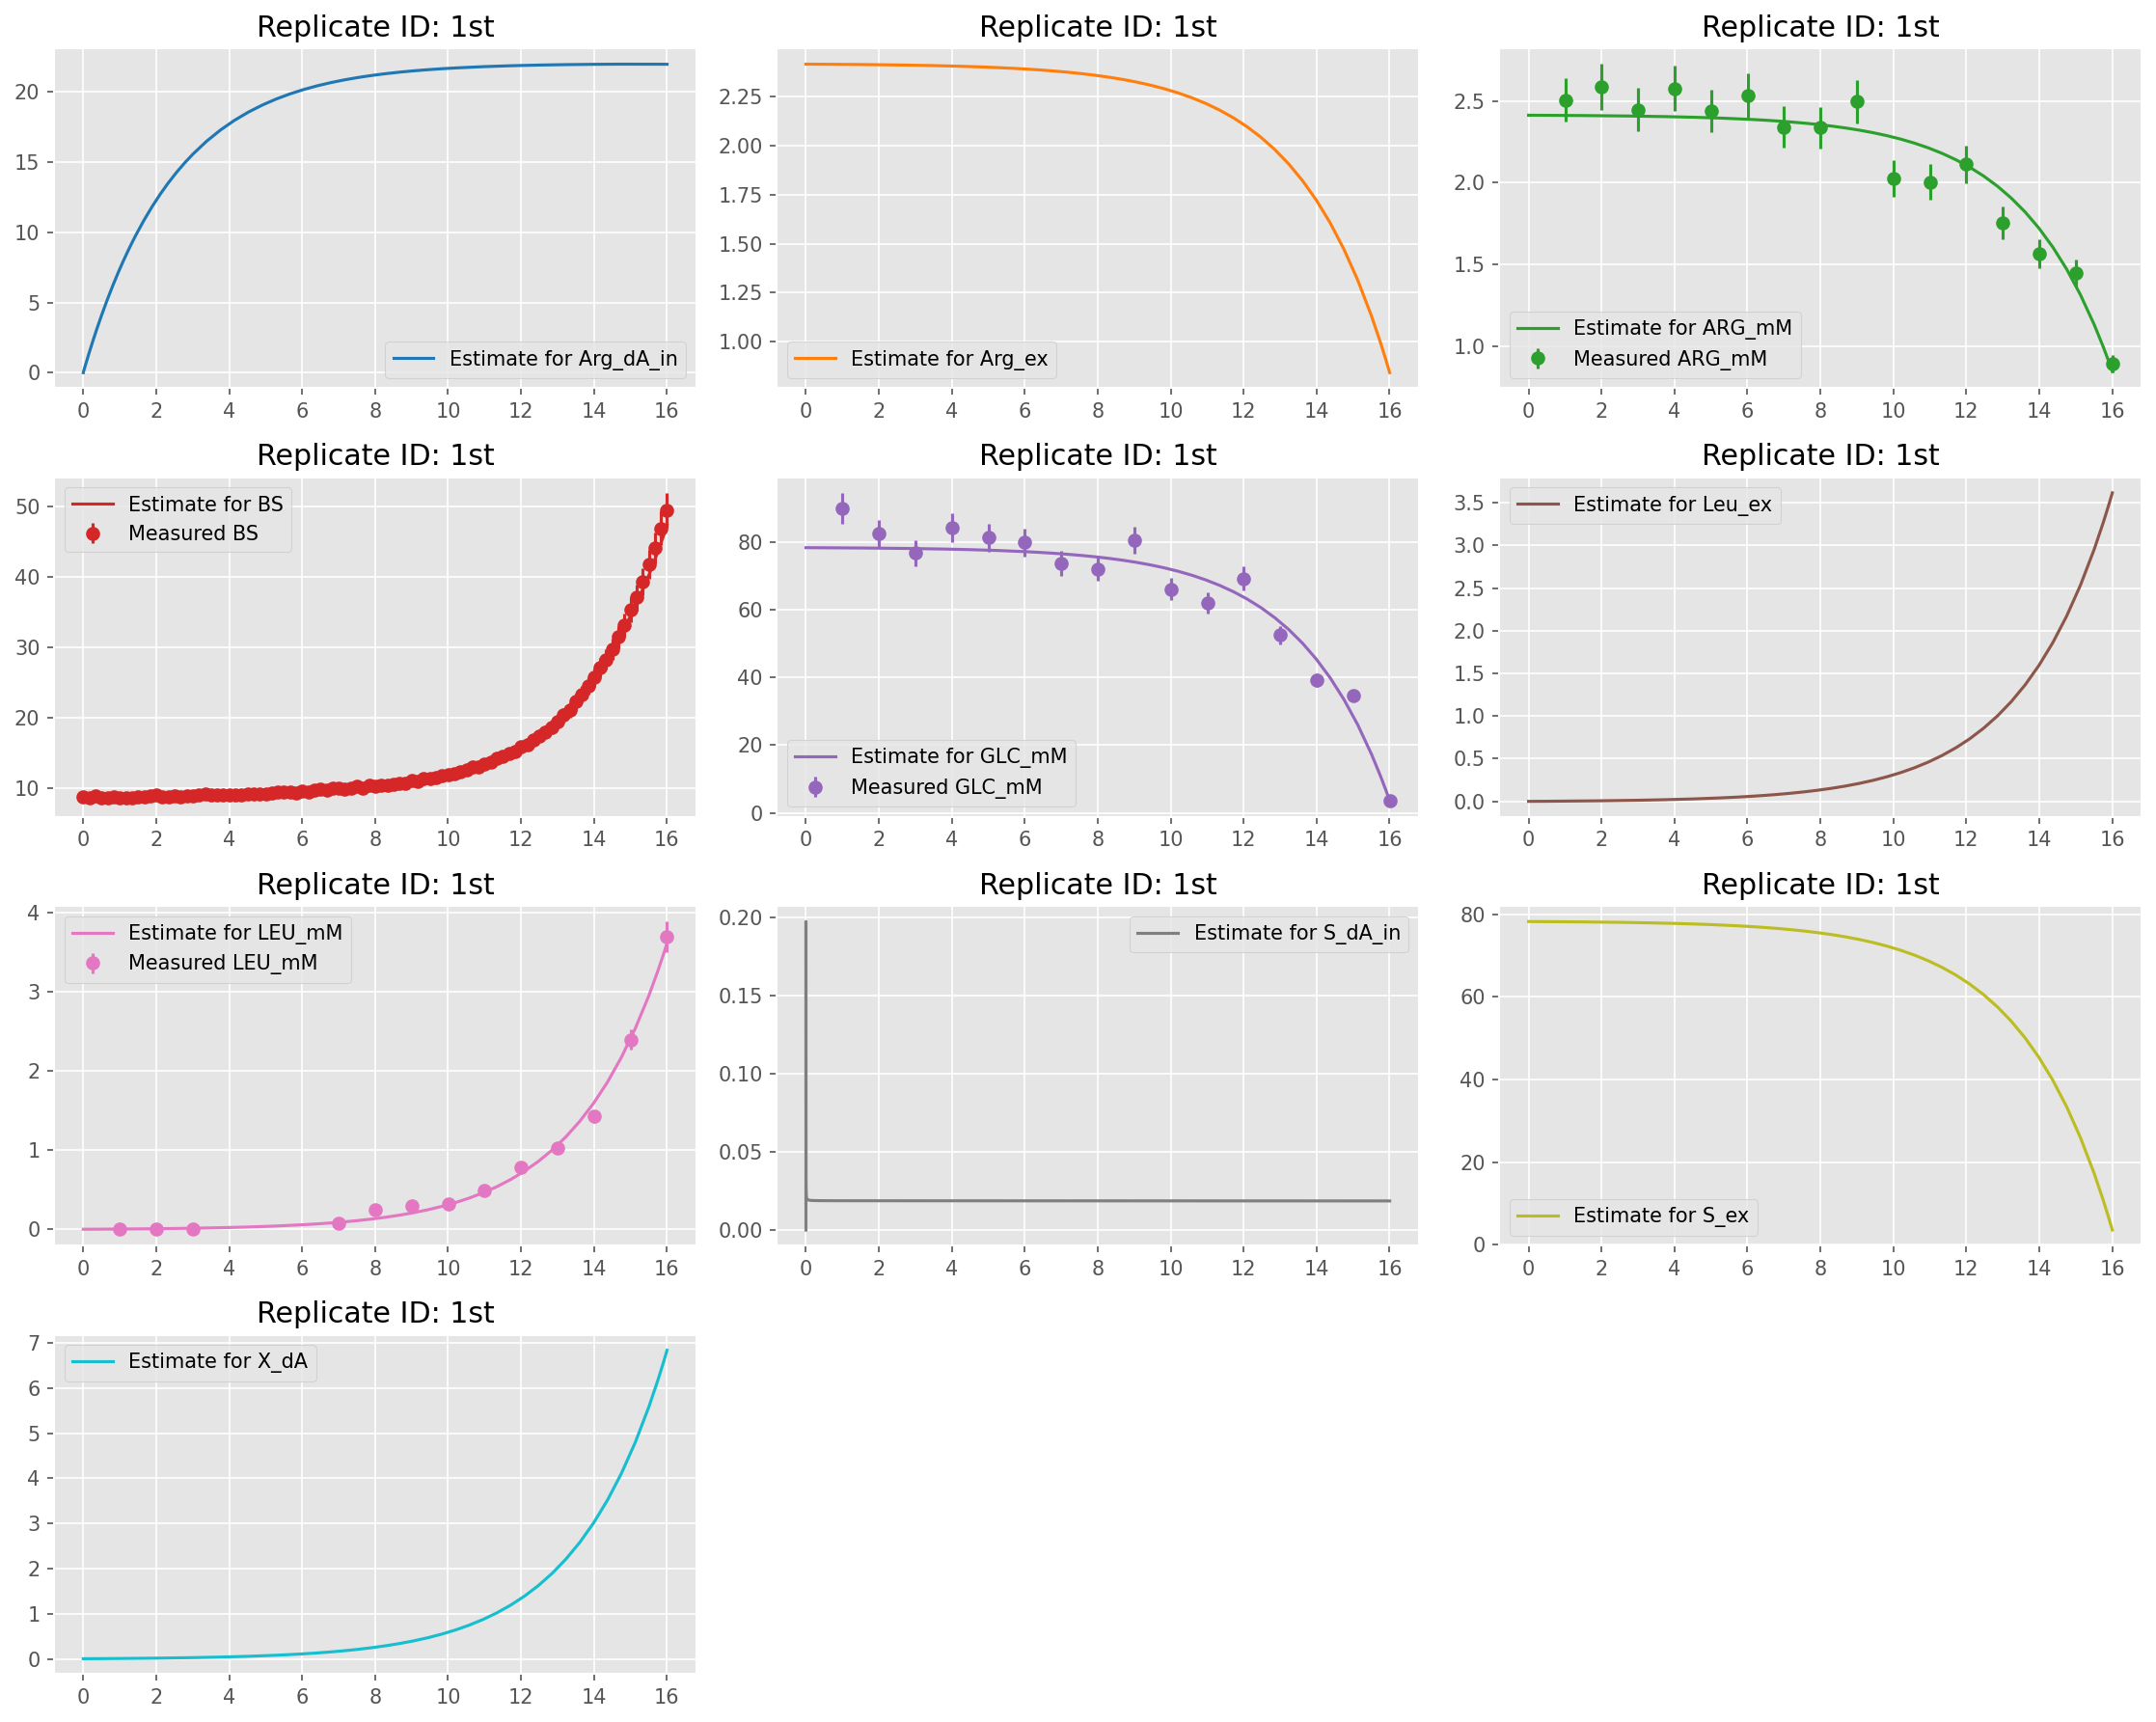

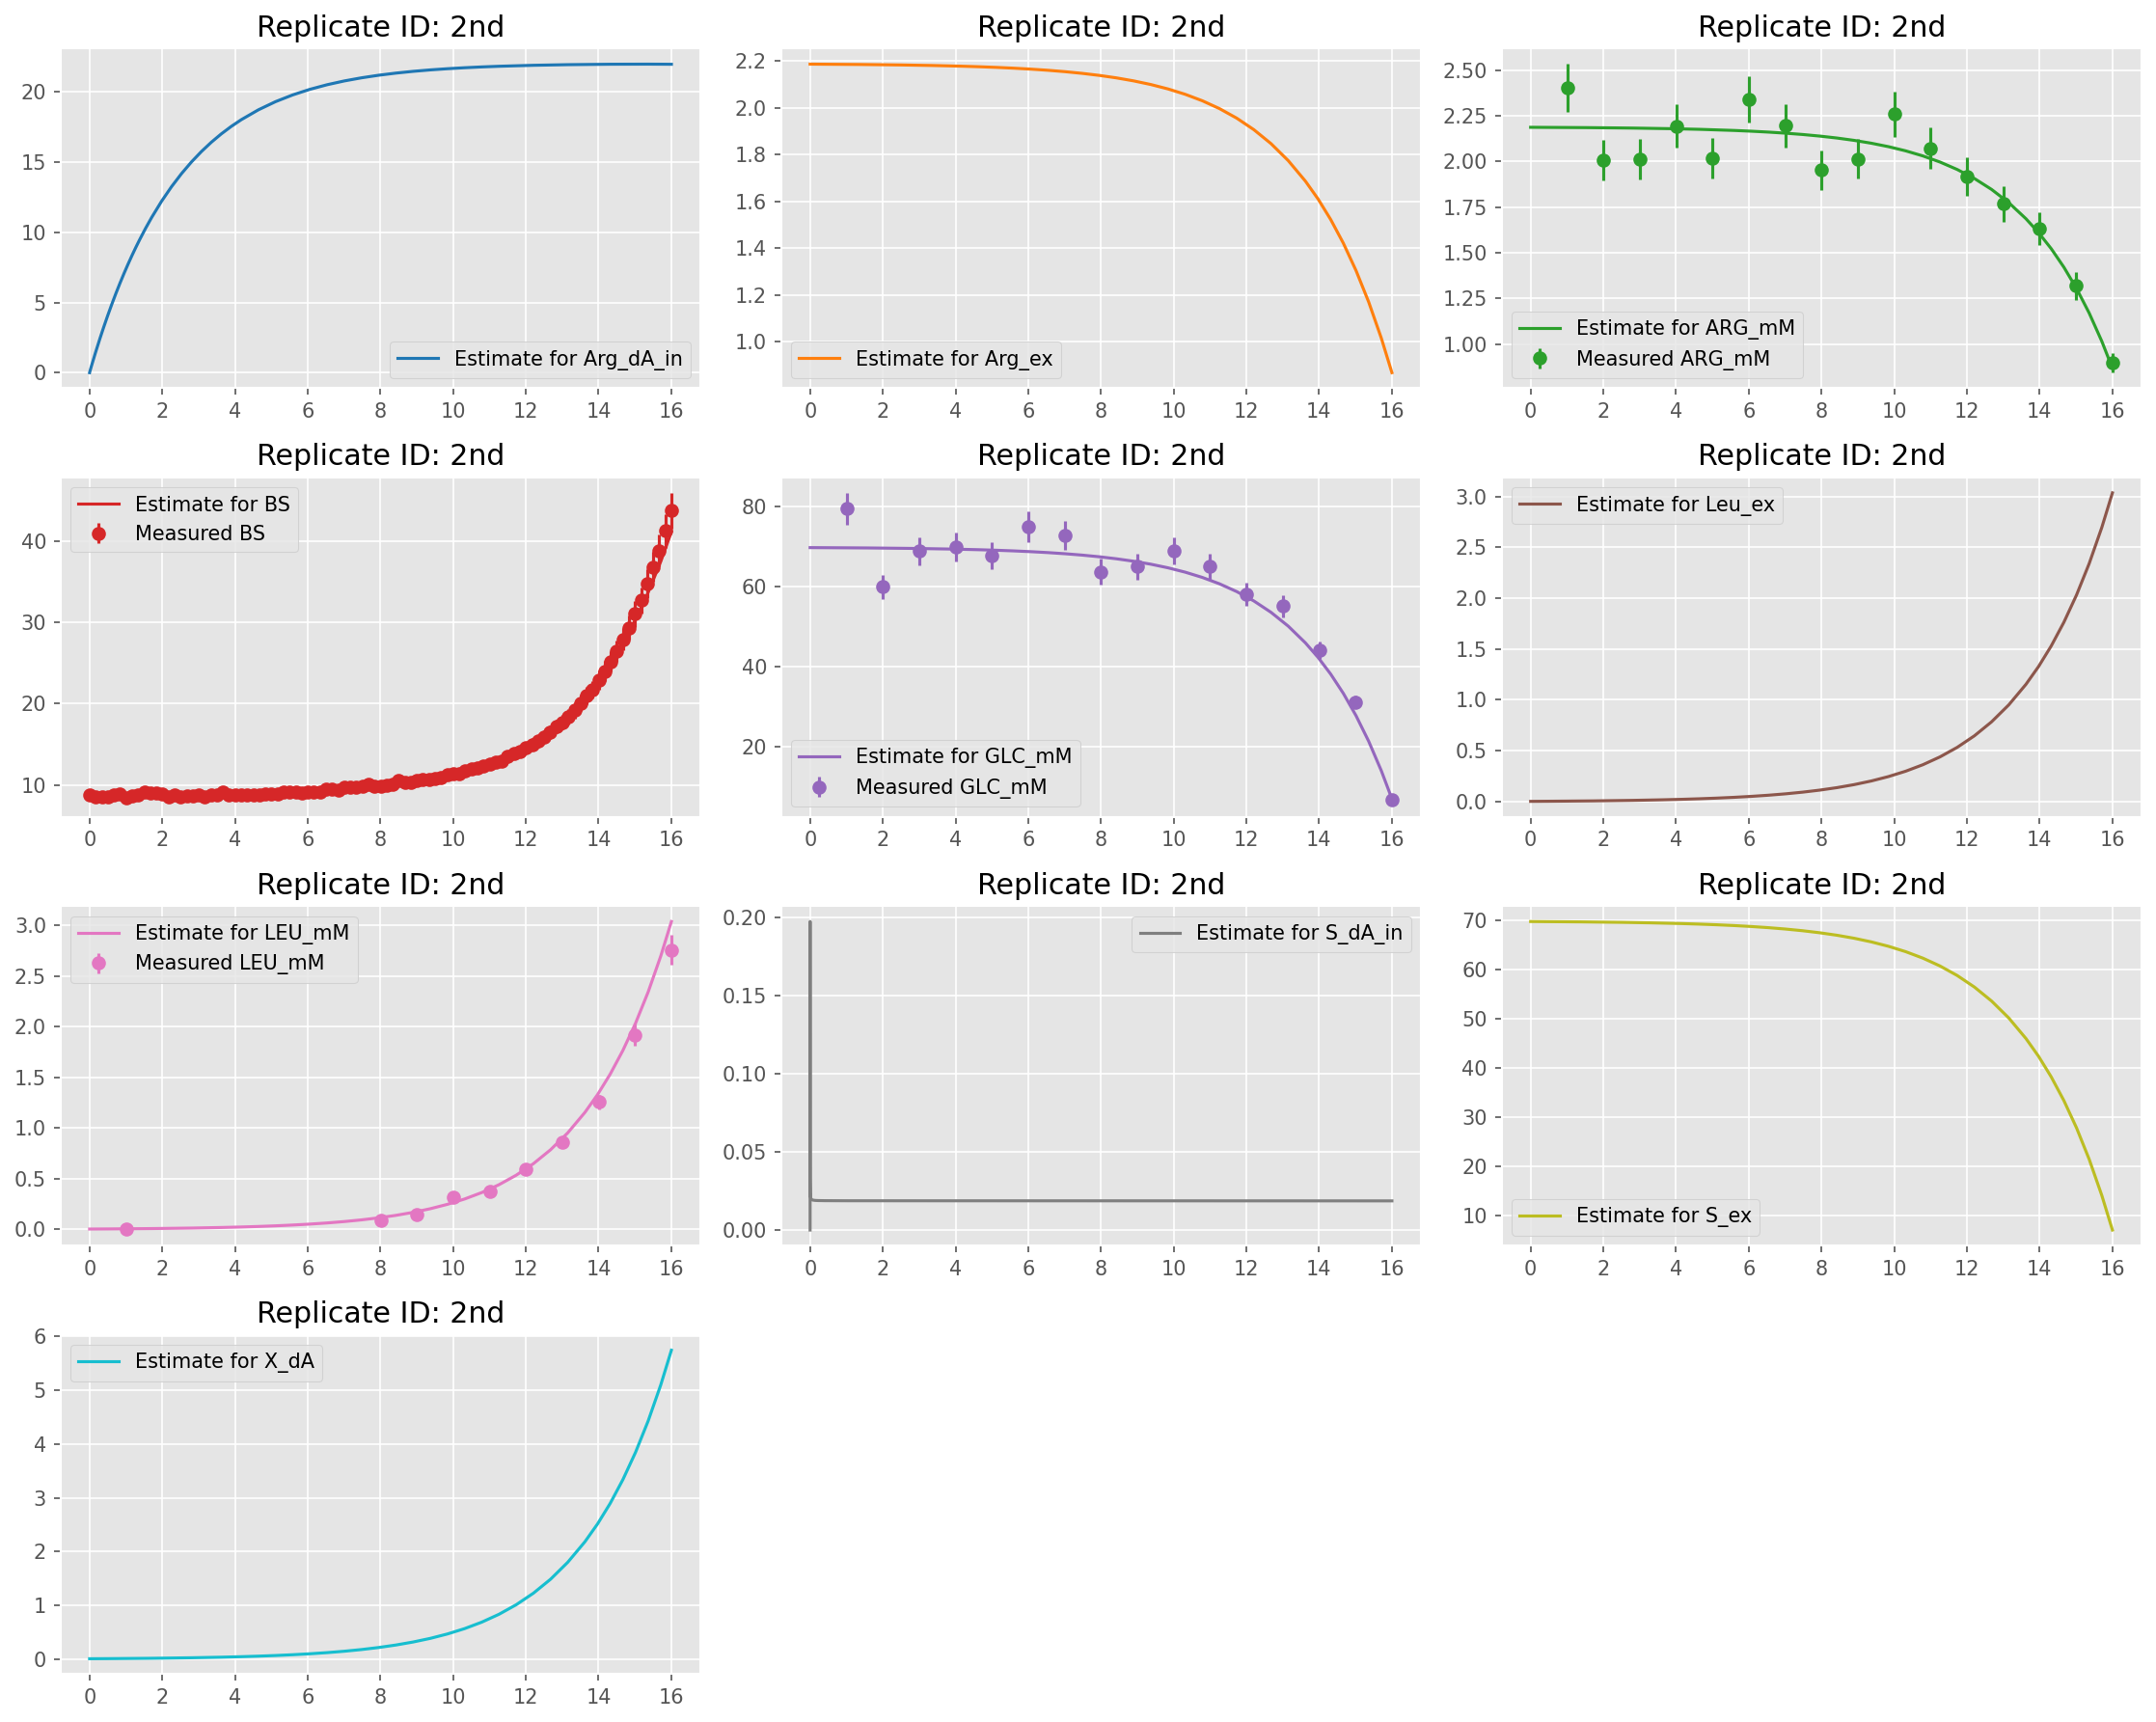

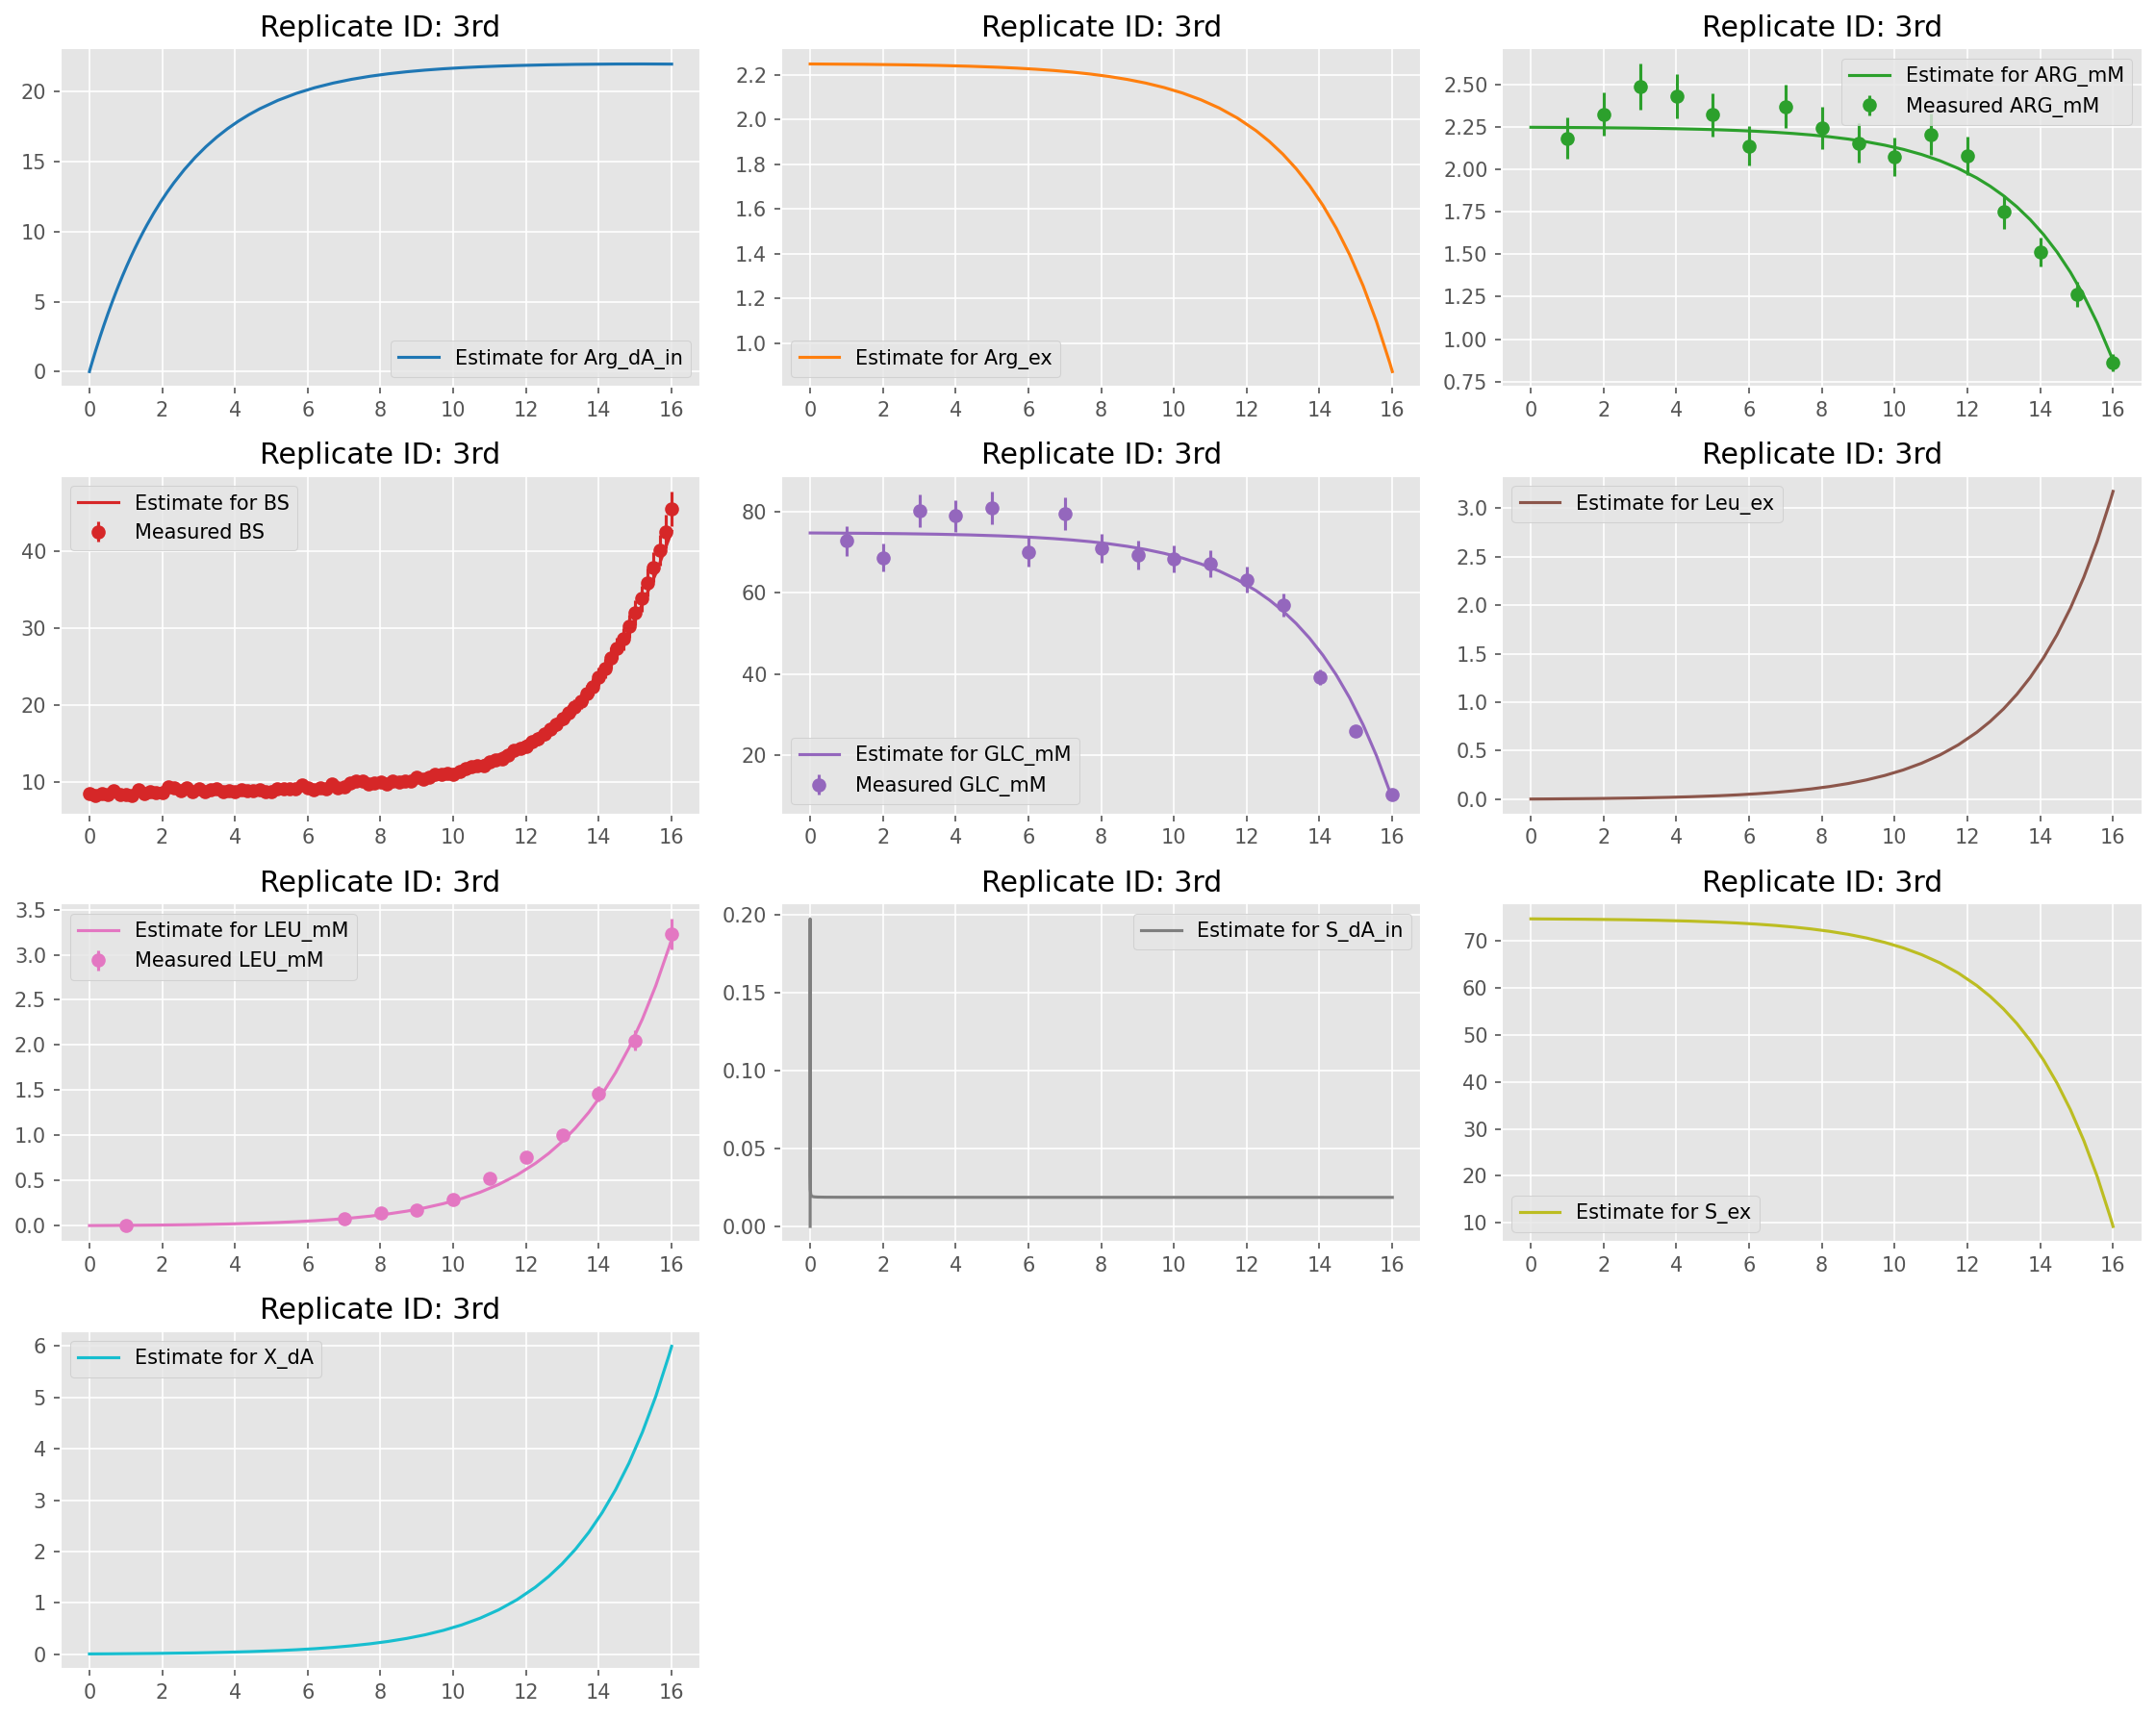

In [12]:
# Compare simulated data to experimental data
_fig4 = Visualization.compare_estimates(parameters=estimates, measurements=data, caretaker=caretaker)

# 6. Define Functions for Evaluation

In [48]:
def plot_rates(mc_data, conos=False, rates_only=True):
    # Distinguish plotsize if conos (more rates)
    if conos and rates_only:
        np = 4
    elif conos and (rates_only == False):
        np = 10
    elif (conos == False) and rates_only:
        np = 2
    else:
        np = 8

    # Initialize figure
    fig, ax_r = plt.subplots(np, 2)
    fig.set_size_inches(18, 4 * np)

    # Get rate-keys if specified
    if rates_only:
        rate_keys = [rate for rate in mc_data.keys() if (str(rate).startswith('v')) or (str(rate).startswith('mu'))]
    else:
        rate_keys = mc_data.keys()

    # initialize plot counters
    i, j = 0, 0

    # Plot all rates
    for rate_name in rate_keys:
        for r in mc_data[rate_name]:
            ax_r[i, j].plot(r[0], r[1], linewidth=0.1, color='red')
        ax_r[i, j].set_title(str(rate_name))
        ax_r[i, j].set_xlim(0, 18)
        ax_r[i, j].set_xlabel('Time [h]')
        if str(rate_name).startswith('mu'):
            ax_r[i, j].set_ylabel(str(rate_name)+ ' [1/h]')
        else:
            ax_r[i, j].set_ylabel(str(rate_name)+ ' [mmol/l_cell*h]')
        # ax_r[i,j].plot(get_mean(mc_data[rate_name]).index,get_mean(mc_data[rate_name]).values,linewidth=1.5, color='black')

        if j == 0:
            i, j = i, j + 1
        else:
            i, j = i + 1, 0
            
    plt.subplots_adjust(
        left     = 0.1,
        right    = 0.9,
        bottom   = 0.1,
        top      = 0.9,
        wspace   = 0.4,
        hspace   = 0.4,
        
    )
    
    
def rate2df(data, rate):
    # Read rate from data
    _data = data[rate]

    # Initialize dict
    _df_list = []

    # Iterate trough mc-samples to fill the list with dataframes
    try:
        for mc in range(len(_data)):
            _df_list.append(pd.DataFrame(_data[mc][1], index=_data[mc][0]))
        keys = range(len(_data))
    except:
        for mc in range(2, len(_data) - 2):
            _df_list.append(pd.DataFrame(_data[mc][1], index=_data[mc][0]))
        keys = range(2, len(_data) - 2)
    # concatenate dataframes & drop unmatching rows
    _df = pd.concat(_df_list, axis=1).dropna().transpose()

    # assign mc_samples as keys
    return _df.reset_index().drop('index', axis=1).transpose()


            
def conv2cell_unit(mc_data, rate: list = ['v_upt_GLC', 'v_upt_ARG','v_syn_LEU']):
                                          
    # Set constant conversion factor: specific cell volume
    V_cell = 1.93 / 1000

    # Initialize result list
    res = []

    # Substrate uptake dA
    if 'v_upt_GLC' in rate:
        v_upt_S_dA = rate2df(mc_data, 'v_upt_GLC')
        v_upt_S_dA = v_upt_S_dA.apply(lambda x: x * V_cell)
        res.append(v_upt_S_dA)

    # Arginine uptake dA
    if 'v_upt_ARG' in rate:
        v_upt_Arg_dA = rate2df(mc_data, 'v_upt_ARG')
        v_upt_Arg_dA = v_upt_Arg_dA.apply(lambda x: x * V_cell)
        res.append(v_upt_Arg_dA)

    # Arginine production dL
    if 'v_syn_LEU' in rate:
        v_syn_Leu_dA = rate2df(mc_data, 'v_syn_LEU')
        v_syn_Leu_dA = v_syn_Leu_dA.apply(lambda x: x * V_cell)
        res.append(v_syn_Leu_dA)

    return res

# 7. Monte Carlo Sampling

In [49]:
optimizers = ['sga', 'compass_search']         # Left out optimizers due to very slow convergence
mult       = 2                                 # Decrease mult to use CPU-Cores for parallel sample computing
evolutions = 40                                # Increase max. number of evolutions to ensure convergence
n_mc       = 30                                # Number of MC-samples produced (low number to aviod RAM overflow)

## 7.1 Calculate / Read MC-Samples

In [50]:
# Not run in script because of huge calculation time

#estimates = caretaker.estimate_parallel_MC_sampling(
#    unknowns=list(unknowns_and_bounds.keys()), 
#    bounds=list(unknowns_and_bounds.values()), 
#    measurements=data, 
#    report_level=5,
#    optimizers=optimizers*mult,
#    rtol_islands=rtol,
#    evolutions=evolutions,
#    mc_samples=n_mc,
#    )

# Export MC-samples to excel (enables clearing RAM and restarting)
#i=1
#while os.path.isfile('dArgLeu_MC_bkp'+str(i)+'.xlsx'):
#    i+=1
#    
#estimates.to_excel('dArgLeu_MC_bkp'+str(i)+'.xlsx')

In [51]:
# Import MC samples for evaluation (For supplement all created files were merged into one)
mc_samples = pandas.read_excel('Monoculture_dARG_LEU++_MC.xlsx', index_col=0)

## 7.2 Calculate Rates for all MC-Samples

In [52]:
# Simulating rates for all MC samples
parameter_slices = Helpers.split_parameters_distributions(mc_samples)

# initialize list for saving simulations
sim_many         = []

# Fix timepoint-vector
t = numpy.linspace(0, 20, 400)

for _par in parameter_slices:
    # Set current parameters and run forward simulation
    caretaker.set_parameters(_par)
    _sim = caretaker.simulate(t=t, parameters=_par)

    # Now calculate all specific rates TimeSeries objects
    specific_rates = []
    for rid in caretaker.replicate_ids:
        specific_rates.extend(
            caretaker.simulators[rid].bioprocess_model.get_specific_rates_time_series(_sim)
        )

    simulation_extended = [*_sim, *specific_rates]
    sim_many.append(simulation_extended)

# Sort Data into RIDs
rep1 = {}
rep2 = {}
rep3 = {}

# Easier format for data handling 
for mcs in range(len(sim_many)):
    for rate in sim_many[mcs]:
        if rate.replicate_id == '1st':
            if rate.name not in rep1.keys():
                rep1[rate.name] = []
                rep1[rate.name].append([rate.timepoints, rate.values])
            else:
                rep1[rate.name].append([rate.timepoints, rate.values])
        if rate.replicate_id == '2nd':
            if rate.name not in rep2.keys():
                rep2[rate.name] = []
                rep2[rate.name].append([rate.timepoints, rate.values])
            else:
                rep2[rate.name].append([rate.timepoints, rate.values])
        if rate.replicate_id == '3rd':
            if rate.name not in rep3.keys():
                rep3[rate.name] = []
                rep3[rate.name].append([rate.timepoints, rate.values])
            else:
                rep3[rate.name].append([rate.timepoints, rate.values])

## 7.3 Convert Units

$[\frac{mmol}{l_{cell}\cdot h}]$ &rarr;  $[\frac{mmol}{gdw\cdot h}]$

In [53]:
#Convert units to per gdw
dA1_c = conv2cell_unit(rep1)
dA1_c.append(rate2df(rep1,'mu'))
dA2_c = conv2cell_unit(rep2)
dA2_c.append(rate2df(rep2,'mu'))
dA3_c = conv2cell_unit(rep3)
dA3_c.append(rate2df(rep3,'mu'))

## 7.4 Plot all Rates

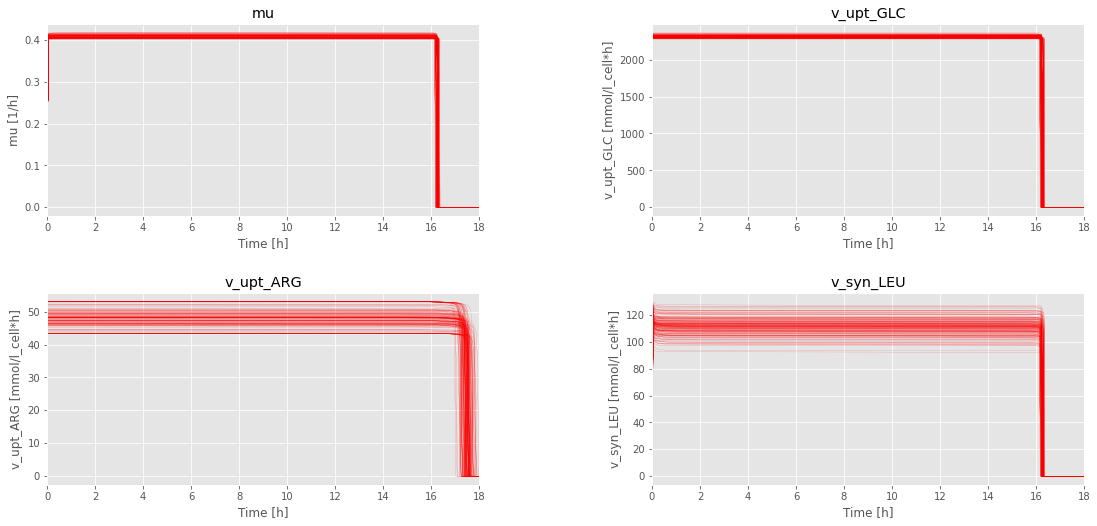

In [54]:
#Examplary for replicate 2
plot_rates(rep2)

In [43]:
# For Mean value calculateion remove non-dynmaic parts:
t_start   = 0.2
t_end     = 15.8


dA1_cut = []
dA2_cut = []
dA3_cut = []

for df in dA1_c:
    df = df[(df.index >= t_start)]
    df = df[(df.index <= t_end)]
    dA1_cut.append(df)


for df in dA2_c:
    df = df[(df.index >= t_start)]
    df = df[(df.index <= t_end)]
    dA2_cut.append(df)
    
for df in dA3_c:
    df = df[(df.index >= t_start)]
    df = df[(df.index <= t_end)]
    dA3_cut.append(df)

## 7.5 Calculate Uncertainties

In [44]:
# Create df with means and max over time
dA1_m   = {}
dA1_max = {}
dA2_m   = {}
dA2_max = {}
dA3_m   = {}
dA3_max = {}

# Use list of rate names as dict keys
rate_names = ['v_upt_GLC', 'v_upt_ARG','v_syn_LEU', 'mu']

#Max for Rep1
i = 0 # iterator for the dict keys
for r in dA1_c:
    dA1_max[rate_names[i]] = r.max(axis=0)
    i+=1
dA1_max = pd.DataFrame(dA1_max)

#Mean for Rep1
i = 0 # iterator for the dict keys
for r in dA1_cut:
    dA1_m[rate_names[i]]   = r.mean(axis=0)
    i+=1
dA1_m   = pd.DataFrame(dA1_m)

#MAX for Rep2
i=0 # reset iterator for the dict keys
for r in dA2_c:
    dA2_max[rate_names[i]] = r.max(axis=0)
    i+=1
dA2_max = pd.DataFrame(dA2_max)

#Mean for Rep2
i=0 # reset iterator for the dict keys
for r in dA2_cut:
    dA2_m[rate_names[i]]   = r.mean(axis=0)
    i+=1
dA2_m   = pd.DataFrame(dA2_m)    

#MAX for Rep3
i=0 # reset iterator for the dict keys
for r in dA3_c:
    dA3_max[rate_names[i]] = r.max(axis=0)
    i+=1
dA3_max = pd.DataFrame(dA3_max)

#Mean for Rep3
i=0 # reset iterator for the dict keys
for r in dA3_cut:
    dA3_m[rate_names[i]]   = r.mean(axis=0)
    i+=1
dA3_m   = pd.DataFrame(dA3_m)  

# Create df with mean and max over replicates
dA_mean = {}
dA_max  = {}
for key in dA2_m.keys():
    dA_mean[key] = np.mean([dA1_m[key].values,dA2_m[key].values,dA3_m[key].values],axis=0)
    dA_max[key]  = np.mean([dA1_max[key].values,dA2_max[key].values,dA3_max[key].values],axis=0)
dA_mean = pd.DataFrame(dA_mean, index=dA2_m.index)
dA_max  = pd.DataFrame(dA_max, index=dA2_max.index)

In [45]:
#Make readable DataFrame 
Eval_ind = ['lb', 'mean', 'ub']
Eval     = pd.DataFrame(np.zeros([3,len(dA_max.keys())]),index=Eval_ind, columns=dA_max.keys())
mEval    = pd.DataFrame(np.zeros([3,len(dA_mean.keys())]),index=Eval_ind, columns=dA_mean.keys())

for key in dA_max.keys():
    Eval.loc['lb'][key]   = dA_max[key].quantile(q=[0.16])
    Eval.loc['mean'][key] = dA_max[key].mean()
    Eval.loc['ub'][key]   = dA_max[key].quantile(q=[0.84])
for key in dA_mean.keys():
    mEval.loc['lb'][key]   = dA_mean[key].quantile(q=[0.16])
    mEval.loc['mean'][key] = dA_mean[key].mean()
    mEval.loc['ub'][key]   = dA_mean[key].quantile(q=[0.84])

In [46]:
mEval

,v_upt_GLC,v_upt_ARG,v_syn_LEU,mu
lb,4.428413,0.087697,0.202655,0.404657
mean,4.458474,0.093127,0.215484,0.407590
ub,4.498554,0.101604,0.226951,0.411244


In [47]:
Eval

,v_upt_GLC,v_upt_ARG,v_syn_LEU,mu
lb,4.428475,0.087708,0.210100,0.404664
mean,4.458535,0.093139,0.221957,0.407600
ub,4.498612,0.101617,0.232269,0.411252
